In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdown
import gdown

file_id = '1owmePKA3WMS7jcw6oY625q59GH3QylYj'
output = 'data_final.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1owmePKA3WMS7jcw6oY625q59GH3QylYj
From (redirected): https://drive.google.com/uc?id=1owmePKA3WMS7jcw6oY625q59GH3QylYj&confirm=t&uuid=67290df5-1fc4-49f0-989c-383cdecee09a
To: /content/data_final.zip
100%|██████████| 165M/165M [00:02<00:00, 75.5MB/s]


'data_final.zip'

In [ ]:
import zipfile

with zipfile.ZipFile('data_final.zip', 'r') as zip_ref:
    zip_ref.extractall('data_final')
print("✅ Data berhasil diekstrak ke folder 'data_final/'")

✅ Data berhasil diekstrak ke folder 'data_final/'


In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [ ]:
# Paths dataset
train_dir = '/content/data_final/content/data_final_split/train'
val_dir = '/content/data_final/content/data_final_split/val'
test_dir = '/content/data_final/content/data_final_split/test'

In [ ]:
# --- Set random seed agar hasil reproducible ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(42)

In [ ]:
# --- Data generators ---
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Cek jumlah kelas dari generator latihan
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

num_classes = train_gen.num_classes # Mendapatkan jumlah kelas secara dinamis

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 12600 images belonging to 12 classes.
Found 2700 images belonging to 12 classes.
Found 2700 images belonging to 12 classes.


In [ ]:
print(f"Jumlah kelas yang terdeteksi oleh generator: {num_classes}")
print(f"Mapping kelas ke indeks: {train_gen.class_indices}")

Jumlah kelas yang terdeteksi oleh generator: 12
Mapping kelas ke indeks: {'Baterai': 0, 'Daun': 1, 'Elektronik': 2, 'Kaca': 3, 'Kardus': 4, 'Kertas': 5, 'Lampu': 6, 'Logam': 7, 'Pakaian': 8, 'Plastik': 9, 'Sampah Makanan': 10, 'Sterofom': 11}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# --- Load base model ---
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Step 1: freeze dulu

# --- Build model ---
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)

# Tambahkan Conv2D + MaxPooling setelah pretrained model
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

# --- Compile awal (head training) ---
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

callbacks = [early_stop, reduce_lr, checkpoint]

# --- Step 1: Train head saja (fit classifier) ---
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# --- Step 2: Fine-tuning EfficientNet (lebih dalam) ---
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False  # Bekukan hanya 50 awal, buka sisanya

# Re-compile dengan learning rate kecil
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Lanjut training ---
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

# --- Gabung hasil training ---
def combine_history(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

full_history = combine_history(history1, history2)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.6475 - loss: 1.2118
Epoch 1: val_accuracy improved from -inf to 0.84296, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 231s 523ms/step - accuracy: 0.6476 - loss: 1.2112 - val_accuracy: 0.8430 - val_loss: 0.4964 - learning_rate: 0.0010
Epoch 2/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7854 - loss: 0.6875
Epoch 2: val_accuracy improved from 0.84296 to 0.87148, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 184s 466ms/step - accuracy: 0.7854 - loss: 0.6875 - val_accuracy: 0.8715 - val_loss: 0.4409 - learning_rate: 0.0010
Epoch 3/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.8141 - loss: 0.5898
Epoch 3: val_accuracy did not improve from 0.87148
394/394 ━━━━━━━━━━━━━━━━━━━━ 184s 468ms/step - accuracy: 0.8141 - loss: 0.5898 - val_accuracy: 0.8700 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 4/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8320 - loss: 0.5460
Epoch 4: val_accuracy improved from 0.87148 to 0.87407, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 185s 470ms/step - accuracy: 0.8320 - loss: 0.5460 - val_accuracy: 0.8741 - val_loss: 0.4015 - learning_rate: 0.0010
Epoch 5/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8399 - loss: 0.5016
Epoch 5: val_accuracy improved from 0.87407 to 0.88074, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 181s 459ms/step - accuracy: 0.8399 - loss: 0.5016 - val_accuracy: 0.8807 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 6/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8504 - loss: 0.4568
Epoch 6: val_accuracy did not improve from 0.88074
394/394 ━━━━━━━━━━━━━━━━━━━━ 180s 457ms/step - accuracy: 0.8504 - loss: 0.4569 - val_accuracy: 0.8770 - val_loss: 0.4342 - learning_rate: 0.0010
Epoch 7/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8477 - loss: 0.4674
Epoch 7: val_accuracy improved from 0.88074 to 0.88667, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 181s 459ms/step - accuracy: 0.8477 - loss: 0.4674 - val_accuracy: 0.8867 - val_loss: 0.4109 - learning_rate: 0.0010
Epoch 8/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8599 - loss: 0.4336
Epoch 8: val_accuracy improved from 0.88667 to 0.89185, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 185s 470ms/step - accuracy: 0.8598 - loss: 0.4336 - val_accuracy: 0.8919 - val_loss: 0.3905 - learning_rate: 0.0010
Epoch 9/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8625 - loss: 0.4205
Epoch 9: val_accuracy improved from 0.89185 to 0.89444, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 181s 460ms/step - accuracy: 0.8625 - loss: 0.4205 - val_accuracy: 0.8944 - val_loss: 0.3948 - learning_rate: 0.0010
Epoch 10/10
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.8668 - loss: 0.4065
Epoch 10: val_accuracy did not improve from 0.89444
394/394 ━━━━━━━━━━━━━━━━━━━━ 205s 468ms/step - accuracy: 0.8668 - loss: 0.4065 - val_accuracy: 0.8933 - val_loss: 0.4277 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 8.
Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5859 - loss: 2.7335
Epoch 1: val_accuracy did not improve from 0.89444
394/394 ━━━━━━━━━━━━━━━━━━━━ 290s 576ms/step - accuracy: 0.5860 - loss: 2.7321 - val_accuracy: 0.8263 - val_loss: 0.7452 - learning_rate: 1.0000e-05
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.6868 - loss: 1.4935
Epoch 2: val_accuracy did not improve from 0.89444
394/394 ━━━━━━━━━━━━━━━━━━━━ 197s 485ms/step - accuracy: 0.6868 - loss: 1.4933 - va

394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.8274 - loss: 0.5576 - val_accuracy: 0.8956 - val_loss: 0.4084 - learning_rate: 1.0000e-05
Epoch 13/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8301 - loss: 0.5384
Epoch 13: val_accuracy did not improve from 0.89556
394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 478ms/step - accuracy: 0.8301 - loss: 0.5383 - val_accuracy: 0.8952 - val_loss: 0.4021 - learning_rate: 1.0000e-05
Epoch 14/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8388 - loss: 0.5038
Epoch 14: val_accuracy did not improve from 0.89556
394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 479ms/step - accuracy: 0.8388 - loss: 0.5038 - val_accuracy: 0.8948 - val_loss: 0.3919 - learning_rate: 1.0000e-05
Epoch 15/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8446 - loss: 0.4813
Epoch 15: val_accuracy improved from 0.89556 to 0.89593, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.8446 - loss: 0.4813 - val_accuracy: 0.8959 - val_loss: 0.3907 - learning_rate: 1.0000e-05
Epoch 16/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8538 - loss: 0.4642
Epoch 16: val_accuracy improved from 0.89593 to 0.89741, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 481ms/step - accuracy: 0.8538 - loss: 0.4642 - val_accuracy: 0.8974 - val_loss: 0.3807 - learning_rate: 1.0000e-05
Epoch 17/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8553 - loss: 0.4474
Epoch 17: val_accuracy did not improve from 0.89741
394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 481ms/step - accuracy: 0.8553 - loss: 0.4474 - val_accuracy: 0.8967 - val_loss: 0.3770 - learning_rate: 1.0000e-05
Epoch 18/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8590 - loss: 0.4290
Epoch 18: val_accuracy improved from 0.89741 to 0.90000, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 481ms/step - accuracy: 0.8590 - loss: 0.4290 - val_accuracy: 0.9000 - val_loss: 0.3681 - learning_rate: 1.0000e-05
Epoch 19/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8624 - loss: 0.4117
Epoch 19: val_accuracy improved from 0.90000 to 0.90370, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 477ms/step - accuracy: 0.8624 - loss: 0.4117 - val_accuracy: 0.9037 - val_loss: 0.3597 - learning_rate: 1.0000e-05
Epoch 20/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8738 - loss: 0.3994
Epoch 20: val_accuracy improved from 0.90370 to 0.90556, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 476ms/step - accuracy: 0.8738 - loss: 0.3993 - val_accuracy: 0.9056 - val_loss: 0.3582 - learning_rate: 1.0000e-05
Epoch 21/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8706 - loss: 0.3839
Epoch 21: val_accuracy improved from 0.90556 to 0.90593, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.8706 - loss: 0.3839 - val_accuracy: 0.9059 - val_loss: 0.3568 - learning_rate: 1.0000e-05
Epoch 22/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8753 - loss: 0.3699
Epoch 22: val_accuracy improved from 0.90593 to 0.90778, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 476ms/step - accuracy: 0.8753 - loss: 0.3699 - val_accuracy: 0.9078 - val_loss: 0.3492 - learning_rate: 1.0000e-05
Epoch 23/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8792 - loss: 0.3709
Epoch 23: val_accuracy did not improve from 0.90778
394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 475ms/step - accuracy: 0.8792 - loss: 0.3709 - val_accuracy: 0.9078 - val_loss: 0.3464 - learning_rate: 1.0000e-05
Epoch 24/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8826 - loss: 0.3544
Epoch 24: val_accuracy improved from 0.90778 to 0.90963, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 476ms/step - accuracy: 0.8826 - loss: 0.3544 - val_accuracy: 0.9096 - val_loss: 0.3435 - learning_rate: 1.0000e-05
Epoch 25/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8847 - loss: 0.3568
Epoch 25: val_accuracy did not improve from 0.90963
394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.8847 - loss: 0.3568 - val_accuracy: 0.9089 - val_loss: 0.3479 - learning_rate: 1.0000e-05
Epoch 26/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8904 - loss: 0.3291
Epoch 26: val_accuracy improved from 0.90963 to 0.91185, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 481ms/step - accuracy: 0.8904 - loss: 0.3291 - val_accuracy: 0.9119 - val_loss: 0.3354 - learning_rate: 1.0000e-05
Epoch 27/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8870 - loss: 0.3313
Epoch 27: val_accuracy did not improve from 0.91185
394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 476ms/step - accuracy: 0.8870 - loss: 0.3312 - val_accuracy: 0.9096 - val_loss: 0.3343 - learning_rate: 1.0000e-05
Epoch 28/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8948 - loss: 0.3130
Epoch 28: val_accuracy did not improve from 0.91185
394/394 ━━━━━━━━━━━━━━━━━━━━ 192s 487ms/step - accuracy: 0.8948 - loss: 0.3130 - val_accuracy: 0.9111 - val_loss: 0.3340 - learning_rate: 1.0000e-05
Epoch 29/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8987 - loss: 0.3049
Epoch 29: val_accuracy improved from 0.91185 to 0.91370, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 198s 477ms/step - accuracy: 0.8987 - loss: 0.3050 - val_accuracy: 0.9137 - val_loss: 0.3284 - learning_rate: 1.0000e-05
Epoch 30/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8965 - loss: 0.3100
Epoch 30: val_accuracy improved from 0.91370 to 0.91407, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 480ms/step - accuracy: 0.8965 - loss: 0.3100 - val_accuracy: 0.9141 - val_loss: 0.3225 - learning_rate: 1.0000e-05
Epoch 31/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8954 - loss: 0.3070
Epoch 31: val_accuracy did not improve from 0.91407
394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 482ms/step - accuracy: 0.8954 - loss: 0.3070 - val_accuracy: 0.9130 - val_loss: 0.3194 - learning_rate: 1.0000e-05
Epoch 32/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8976 - loss: 0.2991
Epoch 32: val_accuracy did not improve from 0.91407
394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 481ms/step - accuracy: 0.8976 - loss: 0.2991 - val_accuracy: 0.9122 - val_loss: 0.3201 - learning_rate: 1.0000e-05
Epoch 33/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8991 - loss: 0.2866
Epoch 33: val_accuracy did not improve from 0.91407
394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 476ms/step - accuracy: 0.8991 - loss: 0.2865 - val_accuracy: 0.9137 - val_loss: 0.3169 - learnin

394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.9098 - loss: 0.2816 - val_accuracy: 0.9159 - val_loss: 0.3158 - learning_rate: 1.0000e-05
Epoch 35/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9071 - loss: 0.2854
Epoch 35: val_accuracy did not improve from 0.91593
394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 480ms/step - accuracy: 0.9071 - loss: 0.2854 - val_accuracy: 0.9159 - val_loss: 0.3116 - learning_rate: 1.0000e-05
Epoch 36/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9125 - loss: 0.2712
Epoch 36: val_accuracy improved from 0.91593 to 0.91704, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 193s 490ms/step - accuracy: 0.9125 - loss: 0.2712 - val_accuracy: 0.9170 - val_loss: 0.3094 - learning_rate: 1.0000e-05
Epoch 37/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9123 - loss: 0.2625
Epoch 37: val_accuracy improved from 0.91704 to 0.91963, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 189s 479ms/step - accuracy: 0.9123 - loss: 0.2625 - val_accuracy: 0.9196 - val_loss: 0.3111 - learning_rate: 1.0000e-05
Epoch 38/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9134 - loss: 0.2566
Epoch 38: val_accuracy did not improve from 0.91963
394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 477ms/step - accuracy: 0.9134 - loss: 0.2566 - val_accuracy: 0.9189 - val_loss: 0.3105 - learning_rate: 1.0000e-05
Epoch 39/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.9149 - loss: 0.2583
Epoch 39: val_accuracy improved from 0.91963 to 0.92259, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 476ms/step - accuracy: 0.9149 - loss: 0.2583 - val_accuracy: 0.9226 - val_loss: 0.3053 - learning_rate: 1.0000e-05
Epoch 40/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9187 - loss: 0.2530
Epoch 40: val_accuracy did not improve from 0.92259
394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 483ms/step - accuracy: 0.9187 - loss: 0.2530 - val_accuracy: 0.9222 - val_loss: 0.3107 - learning_rate: 1.0000e-05
Epoch 41/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9096 - loss: 0.2649
Epoch 41: val_accuracy did not improve from 0.92259
394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 473ms/step - accuracy: 0.9096 - loss: 0.2648 - val_accuracy: 0.9207 - val_loss: 0.3062 - learning_rate: 1.0000e-05
Epoch 42/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.9133 - loss: 0.2586
Epoch 42: val_accuracy did not improve from 0.92259
394/394 ━━━━━━━━━━━━━━━━━━━━ 187s 473ms/step - accuracy: 0.9133 - loss: 0.2586 - val_accuracy: 0.9226 - val_loss: 0.3003 - learnin

394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 483ms/step - accuracy: 0.9257 - loss: 0.2253 - val_accuracy: 0.9252 - val_loss: 0.2946 - learning_rate: 1.0000e-05
Epoch 47/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.9245 - loss: 0.2279
Epoch 47: val_accuracy improved from 0.92519 to 0.92556, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 481ms/step - accuracy: 0.9245 - loss: 0.2279 - val_accuracy: 0.9256 - val_loss: 0.2967 - learning_rate: 1.0000e-05
Epoch 48/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9273 - loss: 0.2160
Epoch 48: val_accuracy improved from 0.92556 to 0.92704, saving model to best_model.h5


394/394 ━━━━━━━━━━━━━━━━━━━━ 191s 484ms/step - accuracy: 0.9273 - loss: 0.2160 - val_accuracy: 0.9270 - val_loss: 0.2957 - learning_rate: 1.0000e-05
Epoch 49/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.9345 - loss: 0.1979
Epoch 49: val_accuracy did not improve from 0.92704
394/394 ━━━━━━━━━━━━━━━━━━━━ 190s 483ms/step - accuracy: 0.9345 - loss: 0.1979 - val_accuracy: 0.9259 - val_loss: 0.2945 - learning_rate: 1.0000e-05
Epoch 50/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.9289 - loss: 0.2065
Epoch 50: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.

Epoch 50: val_accuracy did not improve from 0.92704
394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 477ms/step - accuracy: 0.9289 - loss: 0.2065 - val_accuracy: 0.9244 - val_loss: 0.3012 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 49.


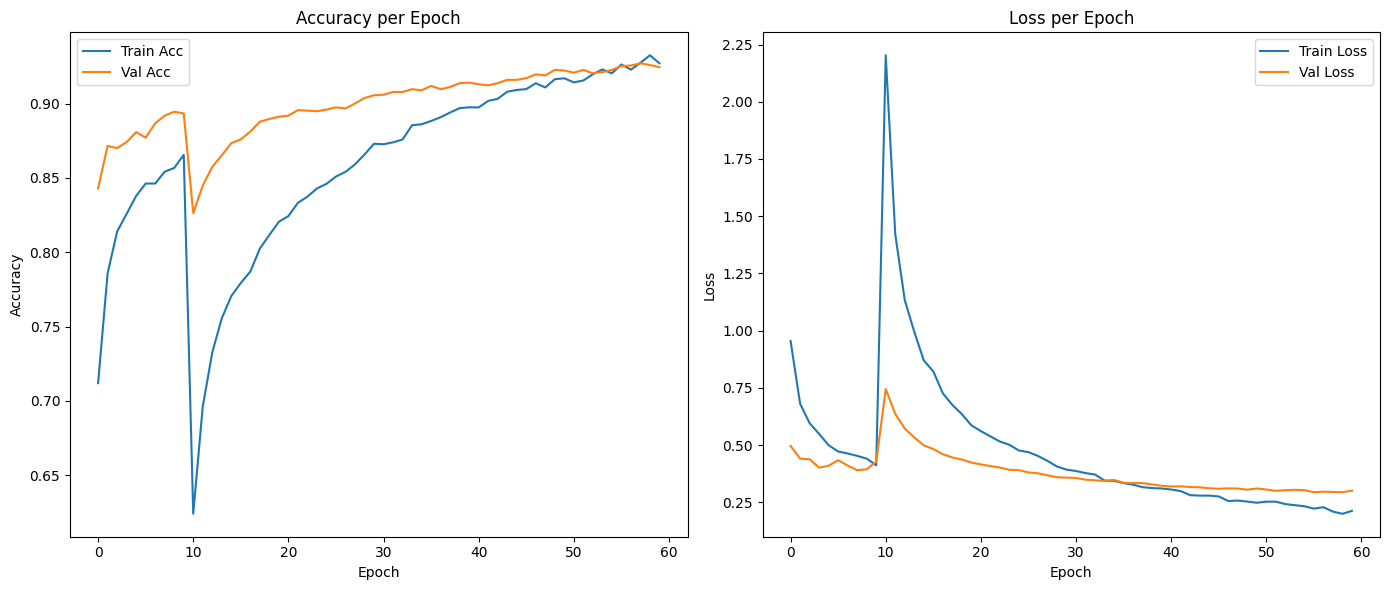

In [ ]:
# --- Plot hasil training ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- Evaluasi di test set ---
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"🧪 Test Loss: {test_loss:.4f}")

 1/85 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.9375 - loss: 0.1067

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9272 - loss: 0.3257

✅ Test Accuracy: 0.9226
🧪 Test Loss: 0.3320


In [ ]:
# --- Prediksi kelas ---
pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step


In [ ]:
# --- Classification report ---
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


📄 Classification Report:
                precision    recall  f1-score   support

       Baterai       0.95      0.92      0.93       225
          Daun       0.96      0.99      0.97       225
    Elektronik       0.88      0.88      0.88       225
          Kaca       0.91      0.91      0.91       225
        Kardus       0.96      0.95      0.95       225
        Kertas       0.84      0.86      0.85       225
         Lampu       0.98      0.96      0.97       225
         Logam       0.81      0.90      0.85       225
       Pakaian       0.99      0.98      0.98       225
       Plastik       0.84      0.78      0.81       225
Sampah Makanan       0.97      0.96      0.97       225
      Sterofom       1.00      0.98      0.99       225

      accuracy                           0.92      2700
     macro avg       0.92      0.92      0.92      2700
  weighted avg       0.92      0.92      0.92      2700



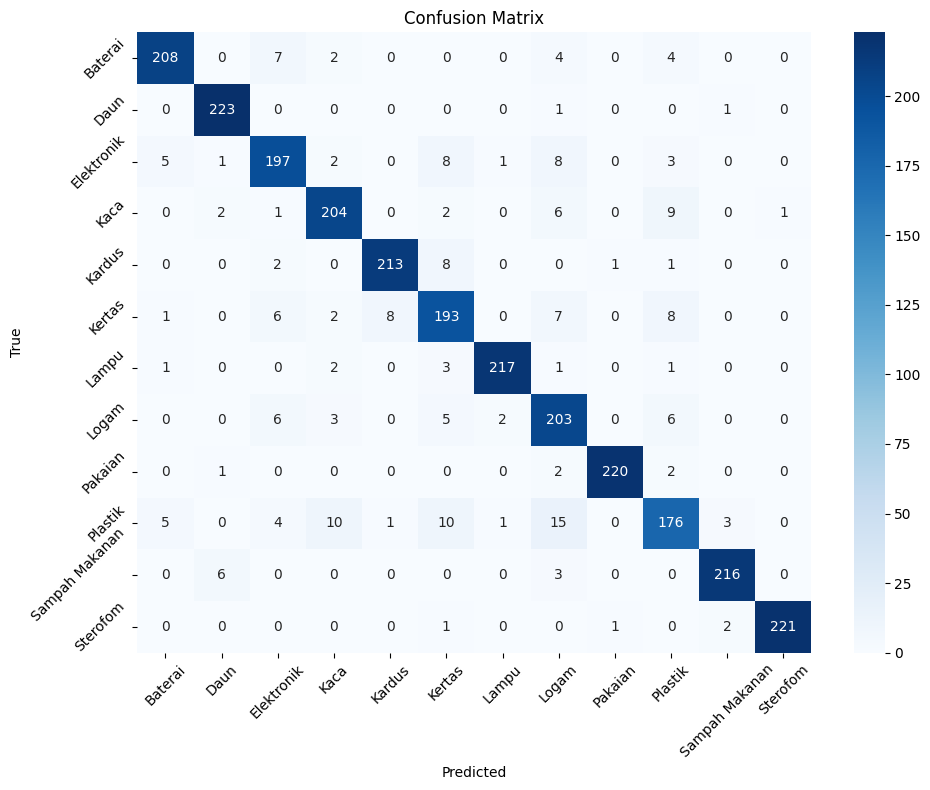

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# --- Load bobot terbaik ---
model.load_weights('best_model.h5')